# Learning a QR code flow

In [1]:
pip install pillow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd "/content/drive/MyDrive/SeminartalkVAEsNFs"

/content/drive/.shortcut-targets-by-id/1qh7NuR-rtGC8StBSNfKzmvFEjuhnsnEn/SeminartalkVAEsNFs


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import MLP
from PIL import Image

## 2 Flow matching for generative modeling

Loaded 2928999 black pixels from a 3000x3000 image.
Log probability density for valid regions: -0.2644


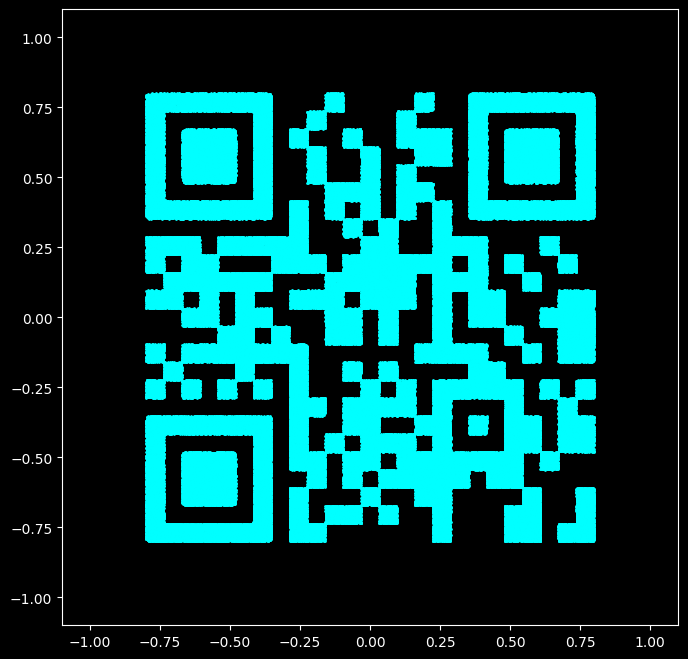


Log probability of test points:
Point (0.0, 0.0): -1000000000.0000
Point (-0.8, 0.8): -1000000000.0000
Point (0.8, 0.8): -1000000000.0000
Point (0.8, -0.8): -0.2644


In [5]:
class QRCodeDistribution:
    """
    Creates a 2D probability distribution from the black pixels of a QR code image.
    The distribution is uniform over the area of the black pixels.
    """
    def __init__(self, image_path, device='cpu'):
        self.device = device

        # 1. Load and process the image
        image = Image.open(image_path).convert('L') # Convert to grayscale
        image_np = np.array(image)
        self.height, self.width = image_np.shape  # Increase the size

        # 2. Binarize the image: < 128 is black (part of the distribution)
        self.binary_mask = torch.from_numpy(image_np < 128).to(self.device)

        # 3. Find the coordinates of all black pixels
        # np.where gives (row_indices, col_indices), which correspond to (y, x)
        y_coords, x_coords = np.where(image_np < 128)

        # 4. Normalize coordinates to the range [-1, 1]
        # We also flip the y-axis so it matches standard plot coordinates (y increases upwards)
        x_norm = (x_coords / (self.width - 1)) * 2 - 1
        y_norm = -((y_coords / (self.height - 1)) * 2 - 1)

        # Stack into a (N, 2) tensor of coordinates
        self.black_pixel_coords = torch.from_numpy(
            np.stack([x_norm, y_norm], axis=1)
        ).float().to(self.device)

        # 5. Calculate the log probability density for the uniform distribution
        # The total number of valid locations
        num_black_pixels = self.black_pixel_coords.shape[0]

        # The area of a single pixel in the [-1, 1] x [-1, 1] space
        pixel_area = (2 / (self.width - 1)) * (2 / (self.height - 1))

        # Total area of the distribution is num_pixels * area_per_pixel
        total_area = num_black_pixels * pixel_area

        # The PDF is 1 / total_area for any point inside a black pixel region
        # and 0 otherwise. The log PDF is -log(total_area).
        self.log_pdf_val = -torch.log(torch.tensor(total_area, device=self.device))

        print(f"Loaded {num_black_pixels} black pixels from a {self.width}x{self.height} image.")
        print(f"Log probability density for valid regions: {self.log_pdf_val.item():.4f}")


    def sample(self, n_samples):
        """
        Draws n_samples uniformly from the set of black pixel coordinates.
        """
        # Generate random indices to pick from our list of valid coordinates
        rand_indices = torch.randint(
            0, self.black_pixel_coords.shape[0], (n_samples,), device=self.device
        )
        return self.black_pixel_coords[rand_indices]

    def log_prob(self, xy_batch):
        """
        Calculates the log probability density for a batch of (x, y) coordinates.
        This is a continuous approximation suitable for normalizing flows.
        """
        # Un-normalize the coordinates back to pixel indices
        x_norm = xy_batch[:, 0]
        y_norm = xy_batch[:, 1]

        # Invert the normalization, clamping to valid image indices
        x_idx = torch.round((x_norm + 1) / 2 * (self.width - 1)).long().clamp(0, self.width - 1)
        y_idx = torch.round((-y_norm + 1) / 2 * (self.height - 1)).long().clamp(0, self.height - 1)

        # Look up whether the corresponding pixel is black using the binary mask
        is_black = self.binary_mask[y_idx, x_idx]

        # Return the pre-calculated log_pdf value for black pixels,
        # and a very low value (log(0) -> -inf) for white pixels.
        return torch.where(
            is_black,
            self.log_pdf_val,
            -1e9 # A large negative number to approximate -inf
        )

# --- Step 3: Visualize the Distribution ---

# Instantiate our custom distribution
qr_code_path = "SciML_QR.png"

qr_dist = QRCodeDistribution(qr_code_path)

# Draw a large number of samples from it
num_samples = 200000
samples = qr_dist.sample(num_samples).cpu().numpy()

# Create a scatter plot of the samples
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(samples[:, 0], samples[:, 1], s=1, alpha=1., color='cyan')

ax.set_aspect('equal', adjustable='box') # Ensure the aspect ratio is correct
ax.set_facecolor('black')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.grid(False)
plt.show()

b)

The base distribution p and target distribution q are symmetrically distributed, with the center of both distributions  aligned near the origin. Thats why the velocity field points towards the center. This confirms the hypothesis.

In [7]:
# Create a grid
grid_size = 50
x = np.linspace(-0.5, 0.5, grid_size)
y = np.linspace(-0.5, 0.5, grid_size)
X, Y = np.meshgrid(x, y)

grid_points = np.stack([X.flatten(), Y.flatten()], axis=-1)
grid_points_torch = torch.tensor(grid_points, dtype=torch.float32, device=device)

# Calculate velocity field
t = torch.zeros(1, device=device)
t_tensor = t.expand(grid_points_torch.size(0), 1)
model_input = torch.cat([grid_points_torch, t_tensor], dim=-1)
v_t = model(model_input)

# Reshape
U = v_t[:, 0].detach().cpu().numpy().reshape(grid_size, grid_size)
V = v_t[:, 1].detach().cpu().numpy().reshape(grid_size, grid_size)

# Plot
plt.figure(figsize=(8, 8))
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=10.0, color='blue', alpha=0.7)
plt.title("Velocity Field at t = 0")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

NameError: name 'device' is not defined

## Fourier mode

100%|██████████| 20000/20000 [10:22<00:00, 32.12it/s]


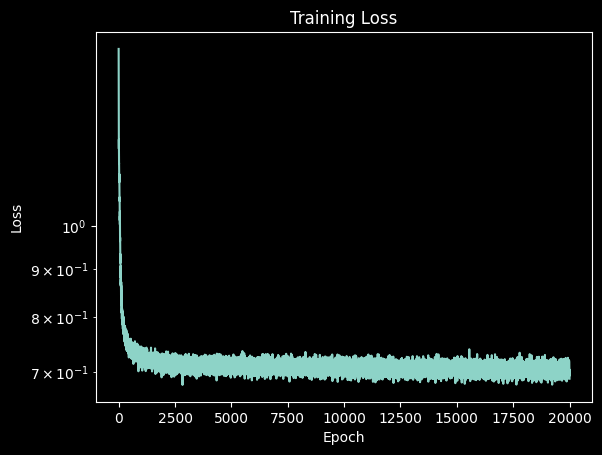

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Enhanced Fourier Feature Network with sinusoidal embeddings
class FourierFeatureNetwork(nn.Module):
    def __init__(self, num_fourier_features=256, hidden_dims=[512, 512, 512, 512], sigma=10.0):
        super().__init__()
        self.B = nn.Parameter(sigma * torch.randn(2, num_fourier_features), requires_grad=False)
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.SiLU(),
            nn.Linear(128, 128)
        )

        # Build MLP with Fourier features
        layers = []
        input_dim = 2 * num_fourier_features + 128  # Fourier features + time embedding

        for i, hdim in enumerate(hidden_dims):
            layers.append(nn.Linear(input_dim, hdim))
            layers.append(nn.SiLU())
            # Layer normalization for stability
            layers.append(nn.LayerNorm(hdim))
            input_dim = hdim

        layers.append(nn.Linear(hidden_dims[-1], 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        # Fourier feature mapping
        proj = 2 * torch.pi * x @ self.B
        fourier_feat = torch.cat([torch.cos(proj), torch.sin(proj)], dim=-1)

        # Time embedding
        t_emb = self.time_embed(t.unsqueeze(-1))

        # Combine features
        combined = torch.cat([fourier_feat, t_emb], dim=-1)
        return self.net(combined)

# Hyperparameters
NUM_FOURIER_FEATURES = 256
HIDDEN_DIMS = [512, 512, 512, 512]
LR = 0.001
NUM_EPOCHS = 20000
BATCH_SIZE = 4096*3  # Larger batch for stability
GRAD_CLIP = 0.5
WARMUP_STEPS = 1000
BASE_DISTRIBUTION_STD = 1.#2.0  # Wider initial distribution

# Initialize model with Fourier features
model = FourierFeatureNetwork(
    num_fourier_features=NUM_FOURIER_FEATURES,
    hidden_dims=HIDDEN_DIMS
).to(device)

# Loss and optimizer with warmup
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR*10,
    total_steps=NUM_EPOCHS,
    pct_start=0.1,
    anneal_strategy='cos'
)

# Training loop with gradient clipping and warmup
losses = []
best_loss = float('inf')

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()

    # Sample data with wider base distribution
    x = torch.randn(BATCH_SIZE, 2).to(device) * BASE_DISTRIBUTION_STD
    y = qr_dist.sample(BATCH_SIZE).to(device)
    t = torch.rand(BATCH_SIZE, 1).to(device)

    # Flow matching
    psi_t = (1 - t) * x + t * y
    v_pred = model(psi_t, t.squeeze())
    v_true = y - x

    # Loss and backprop
    loss = criterion(v_pred, v_true)
    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
    optimizer.step()
    scheduler.step()

    losses.append(loss.item())

    # Validation and sampling
    if epoch % 5000 == 0 or epoch == NUM_EPOCHS - 1:
        model.eval()
        with torch.no_grad():
            # Generate sample
            samples = sample_from_model(model, num_samples=5000)

            # Visualize
            plt.figure(figsize=(8, 8))
            plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.7)
            plt.title(f"Epoch {epoch}")
            plt.xlim(-1, 1) # -4,4
            plt.ylim(-1, 1) # -4,4
            plt.savefig(f"qr_epoch_{epoch}.png", dpi=150)
            plt.close()

        # Save best model
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'best_qr_model.pth')

# Final model save
torch.save(model.state_dict(), 'final_qr_model.pth')

# Plot loss curve
plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig('training_loss.png', dpi=150)

Sampling: 100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


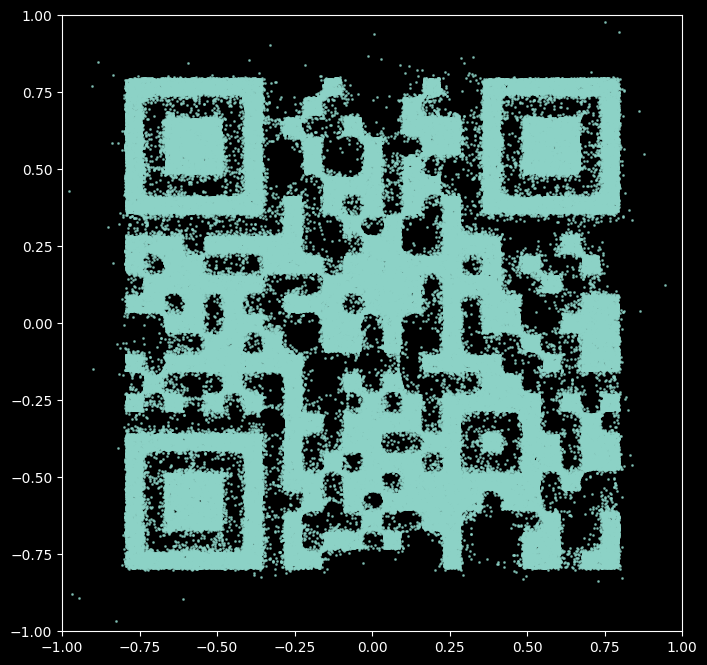

In [9]:
def sample_from_model(model, num_samples=200000, num_steps=100, batch_size=4096):
    """
    Generates large number of samples in memory-efficient batches
    """
    model.eval()
    num_batches = (num_samples + batch_size - 1) // batch_size
    all_samples = []

    with torch.no_grad():
        for batch_idx in tqdm(range(num_batches), desc="Sampling", total=num_batches):
            # Determine current batch size (last batch might be smaller)
            current_batch_size = min(batch_size, num_samples - batch_idx * batch_size)

            # Initialize from Gaussian prior
            x = torch.randn(current_batch_size, 2, device=device) * BASE_DISTRIBUTION_STD

            # Euler integration
            for step in range(num_steps):
                t = torch.full((current_batch_size,), step / num_steps, device=device)
                dx = model(x, t) / num_steps
                x = x + dx

            # Move to CPU and collect
            all_samples.append(x.cpu())

    return torch.cat(all_samples, dim=0).numpy()

samples = sample_from_model(model, num_samples=200000, num_steps=100, batch_size=4096)

plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.7)
plt.xlim(-1, 1) # -4,4
plt.ylim(-1, 1) # -4,4
plt.show()
#plt.savefig(f"qr_epoch_{epoch}.png", dpi=150)

In [10]:
with torch.no_grad():
        # Generate sample
        samples = sample_from_model(model, num_samples=200000)
        print(samples.shape)

Sampling: 100%|██████████| 49/49 [00:18<00:00,  2.63it/s]

(200000, 2)


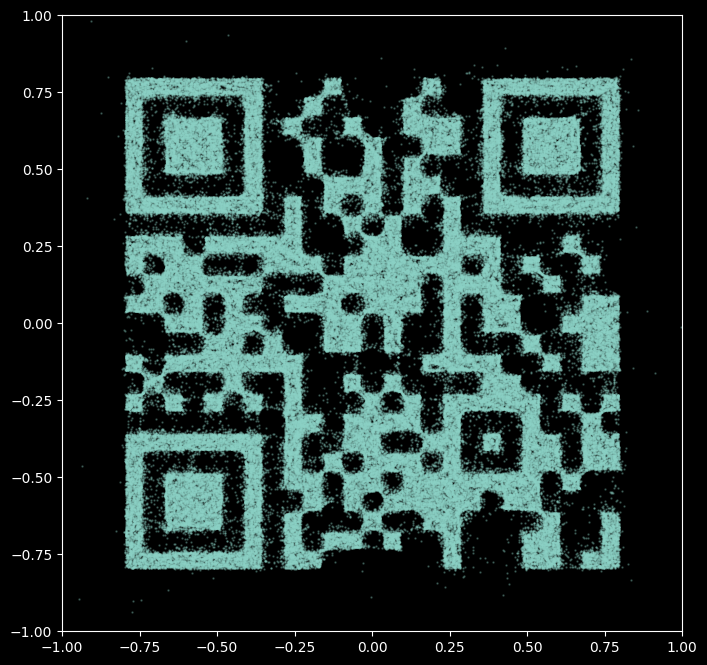

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], s=0.5, alpha=0.3)
plt.xlim(-1, 1) # -4,4
plt.ylim(-1, 1) # -4,4
plt.show()

In [12]:
def generate_flow_trajectory(model, num_samples=5000, num_steps=100):
    """
    Generates the full trajectory of a few samples for animation purposes.

    Args:
        model (torch.nn.Module): The trained flow matching model.
        num_samples (int): The number of data points to animate.
        num_steps (int): The number of integration steps (frames in the animation).

    Returns:
        numpy.ndarray: A tensor of shape (num_steps, num_samples, 2) containing
                       the particle positions at each step.
    """
    model.eval()
    trajectory = []

    with torch.no_grad():
        # 1. Initialize from Gaussian prior
        x = torch.randn(num_samples, 2, device=device) * BASE_DISTRIBUTION_STD

        # 2. Euler integration and store each step
        for step in range(num_steps):
            # Store the current state (move to CPU for collection)
            trajectory.append(x.cpu().clone().numpy())

            # Calculate the time t for the current step
            t = torch.full((num_samples,), step / num_steps, device=device)

            # Get the velocity from the model
            velocity = model(x, t)

            # Update the position
            x = x + velocity / num_steps

    # Also add the final state at t=1
    trajectory.append(x.cpu().clone().numpy())

    return np.stack(trajectory, axis=0)

Generate the animation

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.auto import tqdm
from IPython.display import HTML


# --- 1. Generate the data for the animation ---
NUM_ANIMATION_SAMPLES = 10000
NUM_ANIMATION_STEPS = 50

print("Generating flow trajectory for animation...")
flow_trajectory = generate_flow_trajectory(
    model,
    num_samples=NUM_ANIMATION_SAMPLES,
    num_steps=NUM_ANIMATION_STEPS
)
print("Trajectory shape:", flow_trajectory.shape)


# --- 2. Set up the plot ---
fig, ax = plt.subplots(figsize=(8, 8))

# Set fixed axis limits to prevent the plot from resizing, which is crucial for a smooth animation
plot_lim = BASE_DISTRIBUTION_STD * 1.5
ax.set_xlim(-plot_lim, plot_lim)
ax.set_ylim(-plot_lim, plot_lim)
ax.set_aspect('equal', adjustable='box')
ax.set_title("Flow Matching Animation")

# Create the initial scatter plot. We will update its data in the animation function.
# The initial data is the first frame of our trajectory.
scatter = ax.scatter(flow_trajectory[0, :, 0], flow_trajectory[0, :, 1], alpha=0.7, s=0.5)

# Add a text annotation for the time t
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')


# --- 3. Define the animation update function ---
# This function will be called for each frame of the animation
def update(frame):
    # Get the data for the current frame
    current_positions = flow_trajectory[frame]

    # Update the scatter plot data
    scatter.set_offsets(current_positions)

    # Update the time text
    current_time = frame / NUM_ANIMATION_STEPS
    time_text.set_text(f't = {current_time:.2f}')

    # Return the artists that were updated
    return scatter, time_text


# --- 4. Create and display the animation ---
# The number of frames is the number of steps in our trajectory
num_frames = flow_trajectory.shape[0]

# Create the animation object
# interval: delay between frames in milliseconds
# blit: uses a more efficient drawing technique
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

# To display in a Jupyter Notebook or IPython environment
plt.close(fig) # Prevent static figure from showing
HTML(ani.to_jshtml())

# Or, to save the animation as a GIF (requires 'pillow' writer)
# print("Saving animation to flow_animation.gif...")
ani.save('flow_animation.gif', writer='pillow', fps=20)
# print("Done.")

Generating flow trajectory for animation...
Trajectory shape: (51, 10000, 2)
